# Before we start

We will analyze chest X-ray images to determine the presence of pneumonia.

For this task, we will leverage pretrained models such as ResNet and DenseNet. We will perform both full fine-tuning and partial fine-tuning, followed by an in-depth analysis of the results.

# 1. Data Preprocessing

dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data


In [1]:
import torch
print(torch.__version__)  # Xem phiên bản PyTorch
print(torch.version.cuda) # Xem phiên bản CUDA mà PyTorch hỗ trợ


2.6.0+cu126
12.6


In [ ]:
# !pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import functional as F
import random
device = torch.device('cuda')

In [2]:
data_path = "dataset_pt1"

train_path = os.path.join(data_path, "chest_xray/train")
val_path = os.path.join(data_path, "chest_xray/val")
test_path = os.path.join(data_path, "chest_xray/test")

In [3]:
class make_datas_G(Dataset):  
    # Define a dataset class for batch-wise preprocessing to reduce memory usage 
    def __init__(self, path):
        N_path = os.path.join(path, 'NORMAL')
        P_path = os.path.join(path, 'PNEUMONIA')
        # The dataset is divided into two folders: 'NORMAL' and 'PNEUMONIA', so we separate the data accordingly.
        
        self.images = []
        self.labels = []

        # Load pneumonia images (label = 1)
        for p in os.listdir(P_path):
            self.images.append(os.path.join(P_path, p))
            self.labels.append(1)  

        # Load normal images (label = 0)
        for n in os.listdir(N_path):
            self.images.append(os.path.join(N_path, n))
            self.labels.append(0)  

        # The model will be trained based on these assigned labels.

        # Shuffle the dataset to mix normal and pneumonia images
        data = list(zip(self.images, self.labels))
        random.shuffle(data)
        self.images, self.labels = zip(*data)

        # Define image transformations inside the class since preprocessing remains consistent
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),  # Resize images to 224x224
            transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (since the original images are grayscale)
            transforms.ToTensor(),  # Normalize and convert to tensor
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)
        label = self.labels[idx]

        image = self.transform(image)
        image = image.float()  # Ensure correct data type

        return image, torch.tensor(label)

In [5]:
# Define dataset & dataloader

train_dataset = make_datas_G(train_path)
val_dataset = make_datas_G(val_path)
test_dataset = make_datas_G(test_path)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, pin_memory=True)

In [6]:
train_dataset[0][0].shape

torch.Size([1, 256, 256])

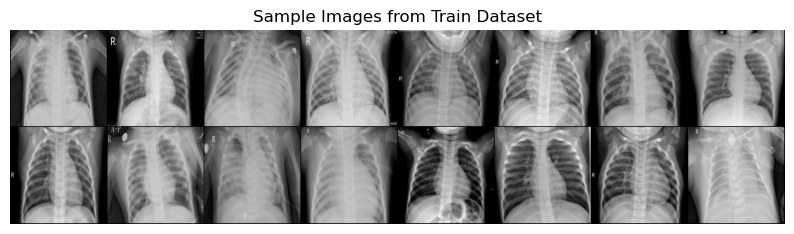

In [7]:
import torchvision.utils as vutils #cung cấp hỗ trợ xử lý hình ảnh

# Lấy một batch từ train_loader
list_image=[train_loader, val_loader, test_loader]
dataiter = iter(list_image[0])
images, labels = next(dataiter)

# Hiển thị ảnh
plt.figure(figsize=(10, 5))
grid = vutils.make_grid(images[:16], nrow=8, normalize=True)  # Ghép 16 ảnh lại thành một lưới
plt.imshow(grid.permute(1, 2, 0))  # Đổi thứ tự kênh để hiển thị đúng
plt.title("Sample Images from Train Dataset")
plt.axis("off")
plt.show()

# 2. Modeling

**Since the data preprocessing step categorizes the images as 0 (normal) or 1 (pneumonia),  
this can be formulated as a binary classification problem.We will compare the performance of ResNet and DenseNet architectures.  
Since both models are pretrained on ImageNet, we assume that fine-tuning these pretrained weights is more efficient than training from scratch.**


## 1) Function Definitions

In [4]:
def test_model(model, dataloader, criterion, optimizer):  
    # Separate function for computing the confusion matrix  
    model.eval()
    correct = 0
    total = 0
    hit, FA, miss, CR = 0, 0, 0, 0  # Initialize confusion matrix components  

    with torch.no_grad():
        for inputs, labels in dataloader:
            
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            hit += torch.sum((predicted == labels) & (labels == 1)).item()  # True Positive (Hit)
            miss += torch.sum((predicted != labels) & (labels == 1)).item()  # False Negative (Miss)
            FA += torch.sum((predicted != labels) & (labels == 0)).item()  # False Positive (False Alarm)
            CR += torch.sum((predicted == labels) & (labels == 0)).item()  # True Negative (Correct Rejection)

    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    return hit, FA, miss, CR  # Return computed values  


def validate_model(model, dataloader):  
    # Evaluate model accuracy on the validation set  
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total  # Return validation accuracy  


def train_model(model, train_loader, val_loader, criterion, optimizer):  
    # Train the model using the training set and evaluate it on the validation set  
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(train_loader, unit="batch") as tepoch:  # Show training progress with tqdm
        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Reset gradients

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()  # Backpropagation
            optimizer.step()  # Update model weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            tepoch.set_postfix(loss=running_loss/len(train_loader), accuracy=100 * correct/total)

    print(f"Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

    val_accuracy = validate_model(model, val_loader)
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

def visualization(): 
    hit, FA, miss, CR = test_model(model, test_loader, criterion, optimizer)
    
    precision = hit/(hit+FA)
    recall = hit/(hit+miss)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    print(f'precision : {precision:-2f}')
    print(f'recall : {recall:-2f}')
    print(f'f1_score : {f1_score:-2f}\n')
    
    
    conf_matrix = np.array([[hit, FA],
                            [miss, CR]])
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d',
                xticklabels=['Actual Pneumonia', 'Actual Normal'],
                yticklabels=['Predicted Pneumonia', 'Predicted Normal'])
    plt.title('Confusion Matrix')
    plt.show()
# def visualization(): 
#     hit, FA, miss, CR = test_model(model, test_loader, criterion, optimizer)
    
#     precision = hit / (hit + FA) if (hit + FA) > 0 else 0
#     recall = hit / (hit + miss) if (hit + miss) > 0 else 0
#     f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

#     print(f'Precision : {precision:.2f}')
#     print(f'Recall    : {recall:.2f}')
#     print(f'F1 Score  : {f1_score:.2f}\n')

#     # Tạo ma trận nhầm lẫn
#     conf_matrix = np.array([[hit, FA],
#                             [miss, CR]])

#     # Vẽ ma trận nhầm lẫn bằng plt
#     fig, ax = plt.subplots(figsize=(6, 5))
#     ax.matshow(conf_matrix, cmap='Blues')

#     # Ghi số lên từng ô của ma trận
#     for i in range(2):
#         for j in range(2):
#             ax.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', fontsize=12, color='black')

#     # Định dạng trục
#     ax.set_xticks([0, 1])
#     ax.set_yticks([0, 1])
#     ax.set_xticklabels(['Actual Pneumonia', 'Actual Normal'])
#     ax.set_yticklabels(['Predicted Pneumonia', 'Predicted Normal'])

#     plt.xlabel('Actual')
#     plt.ylabel('Predicted')
#     plt.title('Confusion Matrix')

#     plt.show()

## 2) Full fine-tuning

### ResNet

In [5]:
ResNetF = models.resnet34(weights=None)

ResNetF.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2, bias=False)  
# # Modify the input channel from 3 (RGB) to 1 (Grayscale)  

ResNetF.fc = nn.Linear(in_features=512, out_features=2, bias=True)  
# Set out_features to 2 for classification  
# This is necessary because CrossEntropyLoss will be used  

100%|██████████| 326/326 [00:40<00:00,  8.15batch/s, accuracy=93.1, loss=0.177] 


Loss: 0.1771, Accuracy: 93.10%
Validation Accuracy: 68.75%


100%|██████████| 326/326 [00:41<00:00,  7.95batch/s, accuracy=96.6, loss=0.0882]


Loss: 0.0882, Accuracy: 96.64%
Validation Accuracy: 87.50%


100%|██████████| 326/326 [00:39<00:00,  8.26batch/s, accuracy=98, loss=0.0566]  


Loss: 0.0566, Accuracy: 98.01%
Validation Accuracy: 87.50%


100%|██████████| 326/326 [00:40<00:00,  8.11batch/s, accuracy=98.3, loss=0.0446] 


Loss: 0.0446, Accuracy: 98.33%
Validation Accuracy: 62.50%


100%|██████████| 326/326 [00:40<00:00,  8.12batch/s, accuracy=98.8, loss=0.034]  


Loss: 0.0340, Accuracy: 98.79%
Validation Accuracy: 93.75%
Test Accuracy: 77.72%
precision : 0.739962
recall : 0.992308
f1_score : 0.847755



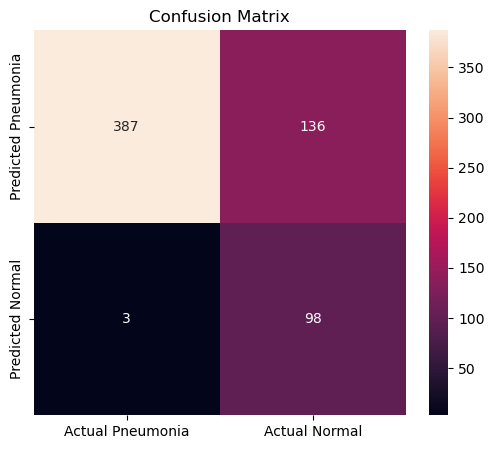

In [21]:
model = ResNetF.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ResNetF.parameters(), lr=0.0001)
epochs = 5
for i in range(epochs):
    train_model(model, train_loader, val_loader, criterion, optimizer)
    torch.cuda.empty_cache()

visualization()

### DenseNet

In [9]:
DenseNetF = models.densenet121(weights='DEFAULT')
DenseNetF.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
DenseNetF.classifier = nn.Linear(in_features=1024, out_features=2, bias=True)

100%|██████████| 326/326 [00:47<00:00,  6.92batch/s, accuracy=96, loss=0.114]   


Loss: 0.1138, Accuracy: 95.95%
Validation Accuracy: 62.50%


100%|██████████| 326/326 [00:46<00:00,  7.03batch/s, accuracy=98.2, loss=0.0506]


Loss: 0.0506, Accuracy: 98.22%
Validation Accuracy: 87.50%


100%|██████████| 326/326 [00:47<00:00,  6.92batch/s, accuracy=99.2, loss=0.0289] 


Loss: 0.0289, Accuracy: 99.16%
Validation Accuracy: 56.25%


100%|██████████| 326/326 [00:48<00:00,  6.79batch/s, accuracy=99.3, loss=0.0236]


Loss: 0.0236, Accuracy: 99.27%
Validation Accuracy: 93.75%


100%|██████████| 326/326 [00:48<00:00,  6.76batch/s, accuracy=99.5, loss=0.0168] 


Loss: 0.0168, Accuracy: 99.46%
Validation Accuracy: 100.00%
Test Accuracy: 88.14%
precision : 0.862385
recall : 0.964103
f1_score : 0.910412



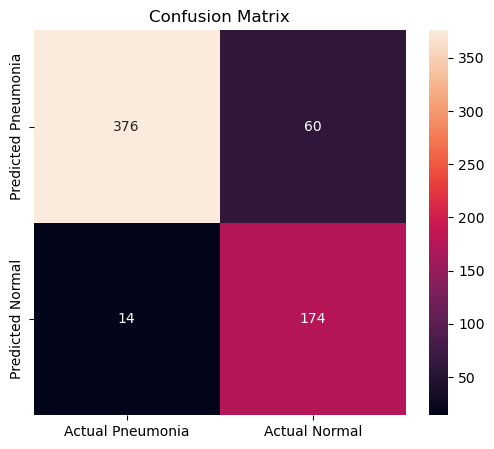

In [24]:
model = DenseNetF.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(DenseNetF.parameters(), lr=0.0001)

epochs = 5
for i in range(epochs):
    train_model(model, train_loader, val_loader, criterion, optimizer)

visualization()

## Partial fine-tuning

### ResNet

In [10]:
ResNet_G = models.resnet34(weights= 'ResNet34_Weights.DEFAULT')

ResNet_G.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2, bias=False)
ResNet_G.fc = nn.Linear(in_features=512, out_features=2, bias=True)

  0%|          | 0/326 [00:00<?, ?batch/s]

100%|██████████| 326/326 [00:40<00:00,  8.10batch/s, accuracy=95.3, loss=0.126] 


Loss: 0.1256, Accuracy: 95.30%
Validation Accuracy: 62.50%


100%|██████████| 326/326 [00:40<00:00,  8.10batch/s, accuracy=98.1, loss=0.0493] 


Loss: 0.0493, Accuracy: 98.08%
Validation Accuracy: 93.75%


100%|██████████| 326/326 [00:39<00:00,  8.17batch/s, accuracy=99.1, loss=0.0306]


Loss: 0.0306, Accuracy: 99.08%
Validation Accuracy: 62.50%


100%|██████████| 326/326 [00:39<00:00,  8.17batch/s, accuracy=99.5, loss=0.0167] 


Loss: 0.0167, Accuracy: 99.46%
Validation Accuracy: 87.50%


100%|██████████| 326/326 [00:39<00:00,  8.24batch/s, accuracy=99.3, loss=0.0195] 


Loss: 0.0195, Accuracy: 99.31%
Validation Accuracy: 100.00%
Test Accuracy: 83.81%
precision : 0.795501
recall : 0.997436
f1_score : 0.885097



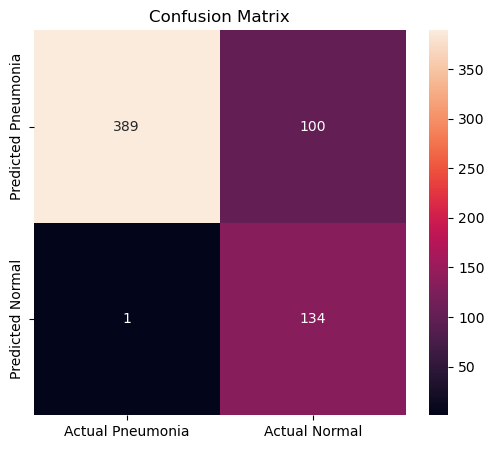

In [28]:
model = ResNet_G.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ResNet_G.parameters(), lr=0.0001)
epochs = 5
for i in range(epochs):
    train_model(model, train_loader, val_loader, criterion, optimizer)

visualization()

### DenseNet

In [11]:
DenseNet_G = models.densenet201(weights = 'DEFAULT')

DenseNet_G.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
DenseNet_G.classifier = nn.Linear(in_features=1920, out_features=2, bias=True)

100%|██████████| 326/326 [00:59<00:00,  5.47batch/s, accuracy=95.7, loss=0.112] 


Loss: 0.1119, Accuracy: 95.67%
Validation Accuracy: 100.00%


100%|██████████| 326/326 [00:59<00:00,  5.50batch/s, accuracy=98.4, loss=0.0448] 


Loss: 0.0448, Accuracy: 98.45%
Validation Accuracy: 93.75%


100%|██████████| 326/326 [00:58<00:00,  5.54batch/s, accuracy=99.1, loss=0.025]  


Loss: 0.0250, Accuracy: 99.14%
Validation Accuracy: 87.50%
Test Accuracy: 81.09%
precision : 0.769841
recall : 0.994872
f1_score : 0.868009



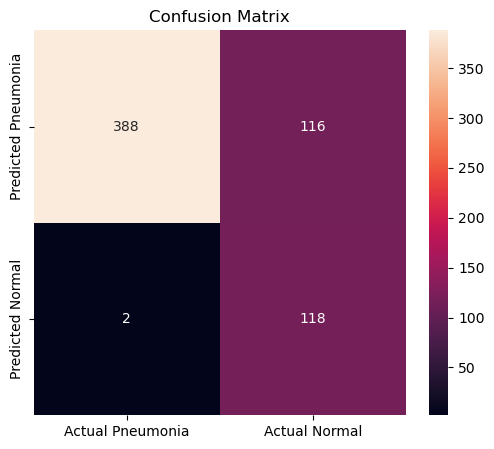

In [32]:
model = DenseNet_G.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(DenseNet_G.parameters(), lr=0.0001)

epochs = 3
for i in range(epochs):
    train_model(model, train_loader, val_loader, criterion, optimizer)

visualization()

# 3. GrayScale to RGB

## 1) Reprocessing Data (to RGB)

In [33]:
class make_datas_RGB(Dataset):
    def __init__(self, path):
        N_path = os.path.join(path, 'NORMAL')
        P_path = os.path.join(path, 'PNEUMONIA')
        self.images = []
        self.labels = []

        for p in os.listdir(P_path):
            self.images.append(os.path.join(P_path, p))
            self.labels.append(1)

        for n in os.listdir(N_path):
            self.images.append(os.path.join(N_path, n))
            self.labels.append(0)


        self.transform = transforms.Compose([
                        transforms.Grayscale(num_output_channels=3),  # Grayscale to RGB
                        transforms.Resize((224, 224)),
                        transforms.ToTensor()
                    ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)

        label = self.labels[idx]

        image = self.transform(image)
        image = image.float()

        return image, torch.tensor(label)

In [34]:
train_dataset = make_datas_RGB(train_path)
val_dataset = make_datas_RGB(val_path)
test_dataset = make_datas_RGB(test_path)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, pin_memory=True)

## 2) Full fine-tuning

### ResNet

In [35]:
ResNetFF = models.resnet34(weights=None)
ResNetFF.fc = nn.Linear(in_features=512, out_features=2, bias=True)


100%|██████████| 326/326 [01:16<00:00,  4.26batch/s, accuracy=92.4, loss=0.192] 


Loss: 0.1923, Accuracy: 92.41%
Validation Accuracy: 75.00%


100%|██████████| 326/326 [01:21<00:00,  4.01batch/s, accuracy=97.1, loss=0.0877]


Loss: 0.0877, Accuracy: 97.09%
Validation Accuracy: 75.00%


100%|██████████| 326/326 [01:20<00:00,  4.04batch/s, accuracy=97.7, loss=0.0601]


Loss: 0.0601, Accuracy: 97.70%
Validation Accuracy: 75.00%
Test Accuracy: 78.21%
precision : 0.743295
recall : 0.994872
f1_score : 0.850877



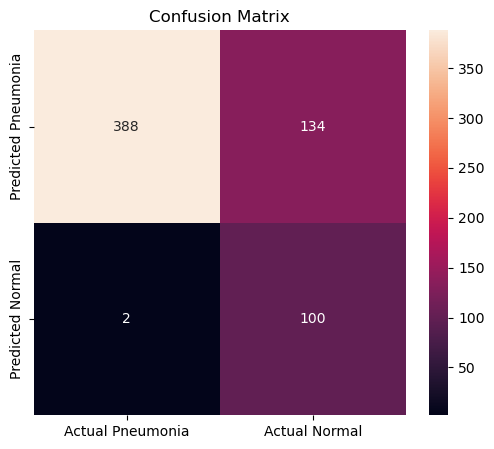

In [36]:
model = ResNetFF.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ResNetFF.parameters(), lr=0.0001)
epochs = 3
for i in range(epochs):
    train_model(model, train_loader, val_loader, criterion, optimizer)

visualization()

### DenseNet

In [37]:
DenseNetFF = models.densenet121(weights=None)
DenseNetFF.classifier = nn.Linear(in_features=1024, out_features=2, bias=True)


100%|██████████| 326/326 [01:27<00:00,  3.71batch/s, accuracy=93.1, loss=0.183] 


Loss: 0.1830, Accuracy: 93.06%
Validation Accuracy: 87.50%


100%|██████████| 326/326 [01:33<00:00,  3.48batch/s, accuracy=96.6, loss=0.0936]


Loss: 0.0936, Accuracy: 96.61%
Validation Accuracy: 56.25%


100%|██████████| 326/326 [01:29<00:00,  3.64batch/s, accuracy=97, loss=0.0813]  


Loss: 0.0813, Accuracy: 96.99%
Validation Accuracy: 75.00%
Test Accuracy: 80.77%
precision : 0.766798
recall : 0.994872
f1_score : 0.866071



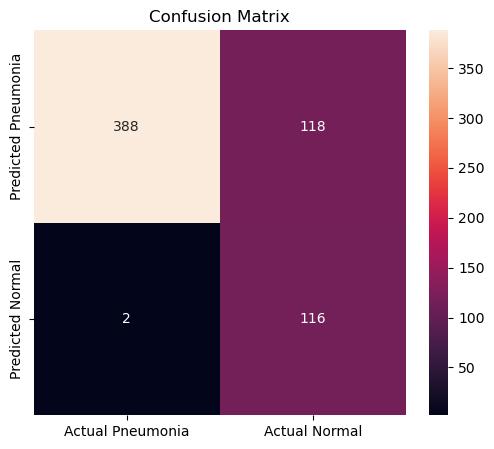

In [38]:
model = DenseNetFF.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(DenseNetFF.parameters(), lr=0.0001)

epochs = 3
for i in range(epochs):
    train_model(model, train_loader, val_loader, criterion, optimizer)

visualization()

## 3) Partial fine-tuning

### ResNet

In [41]:
torch.cuda.empty_cache()

In [42]:
ResNet_RGB = models.resnet34(weights= 'ResNet34_Weights.DEFAULT')
ResNet_RGB.fc = nn.Linear(in_features=512, out_features=2, bias=True)


100%|██████████| 326/326 [01:20<00:00,  4.07batch/s, accuracy=96.1, loss=0.106] 


Loss: 0.1056, Accuracy: 96.13%
Validation Accuracy: 68.75%


100%|██████████| 326/326 [01:21<00:00,  4.01batch/s, accuracy=98.7, loss=0.0429]


Loss: 0.0429, Accuracy: 98.66%
Validation Accuracy: 93.75%


100%|██████████| 326/326 [01:20<00:00,  4.02batch/s, accuracy=99.3, loss=0.0248] 


Loss: 0.0248, Accuracy: 99.25%
Validation Accuracy: 93.75%
Test Accuracy: 85.26%
precision : 0.811715
recall : 0.994872
f1_score : 0.894009



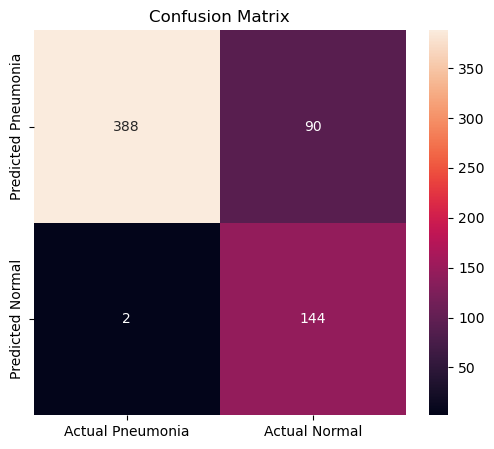

In [43]:
model = ResNet_RGB.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ResNet_RGB.parameters(), lr=0.0001)
epochs = 3
for i in range(epochs):
    train_model(model, train_loader, val_loader, criterion, optimizer)

visualization()

### DenseNet

In [44]:
DenseNet_RGB = models.densenet121(weights = 'DenseNet121_Weights.DEFAULT')
DenseNet_RGB.classifier = nn.Linear(in_features=1024, out_features=2, bias=True)


100%|██████████| 326/326 [01:22<00:00,  3.97batch/s, accuracy=96.1, loss=0.104] 


Loss: 0.1039, Accuracy: 96.15%
Validation Accuracy: 75.00%


100%|██████████| 326/326 [01:22<00:00,  3.97batch/s, accuracy=98.8, loss=0.0351]


Loss: 0.0351, Accuracy: 98.79%
Validation Accuracy: 93.75%


100%|██████████| 326/326 [01:22<00:00,  3.94batch/s, accuracy=99.2, loss=0.0255] 


Loss: 0.0255, Accuracy: 99.18%
Validation Accuracy: 87.50%
Test Accuracy: 82.69%
precision : 0.784274
recall : 0.997436
f1_score : 0.878104



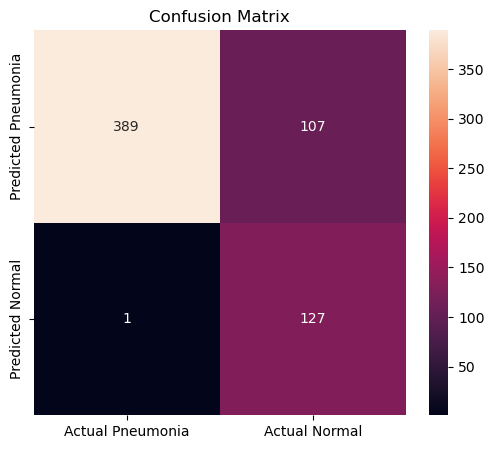

In [45]:
model = DenseNet_RGB.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(DenseNet_RGB.parameters(), lr=0.0001)

epochs = 3
for i in range(epochs):
    train_model(model, train_loader, val_loader, criterion, optimizer)
    torch.cuda.empty_cache()

visualization()

# 4. eXplainable AI (with CAM)

In [46]:
train_dataset = make_datas_G(train_path)
val_dataset = make_datas_G(val_path)
test_dataset = make_datas_G(test_path)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False,num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False,num_workers=4, pin_memory=True)

## 1) Function Definitions

In [14]:
def CAM_View_res(img, model):
    model.eval()

    mean = torch.tensor([0.5]).to(img.device)
    std = torch.tensor([0.5]).to(img.device)
    img_display = img * std + mean

    features_extractor = nn.Sequential(*list(model.children())[:-2])
    output = model(img)

    class_idx = int(output.argmax())

    weights = model.fc.weight[class_idx].reshape(-1, 1, 1)
    features_output = features_extractor(img).squeeze()

    cam = features_output * weights
    cam = torch.sum(cam, dim=0)

    cam = F.interpolate(
        input=cam.unsqueeze(0).unsqueeze(0),
        size=(img.shape[2], img.shape[3]),
        mode="bilinear"
    ).squeeze().cpu().detach().numpy()

    plt.figure(figsize=(8, 8))
    plt.imshow(img_display.cpu().squeeze(), cmap="gray")
    plt.imshow(cam, cmap="jet", alpha=0.4)
    plt.axis("off")
    plt.show()

    return class_idx

## 2) GrayScale / partial fine-tuning

### ResNet

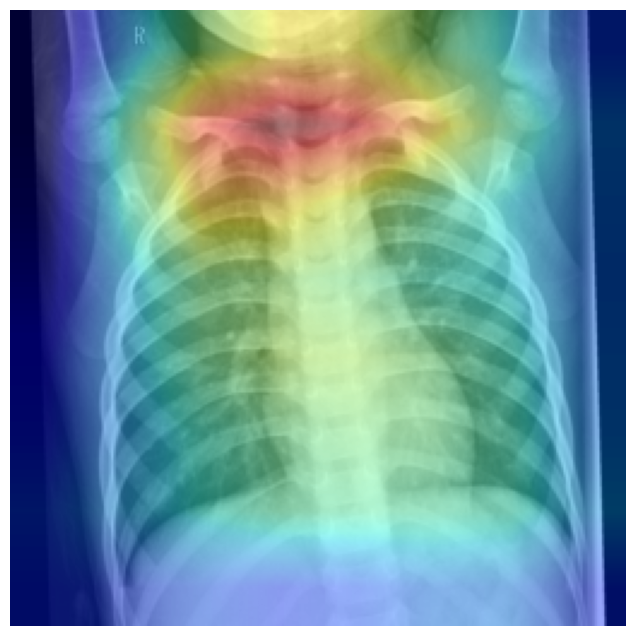

predict : 0 / ans : 0



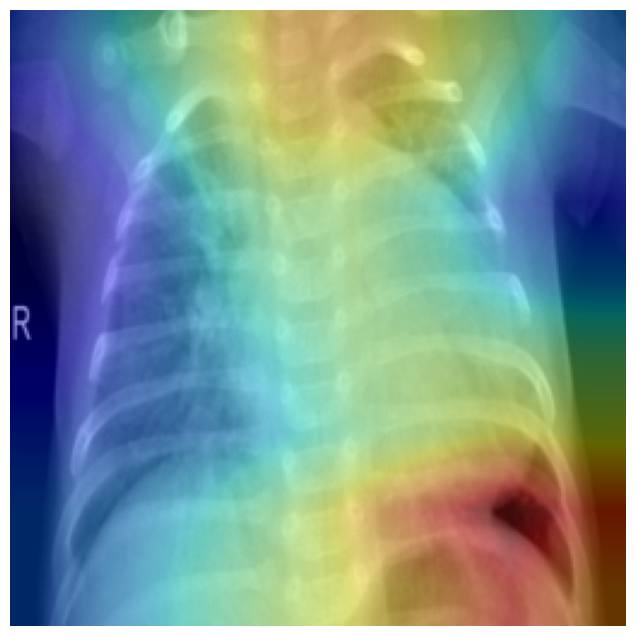

predict : 1 / ans : 1



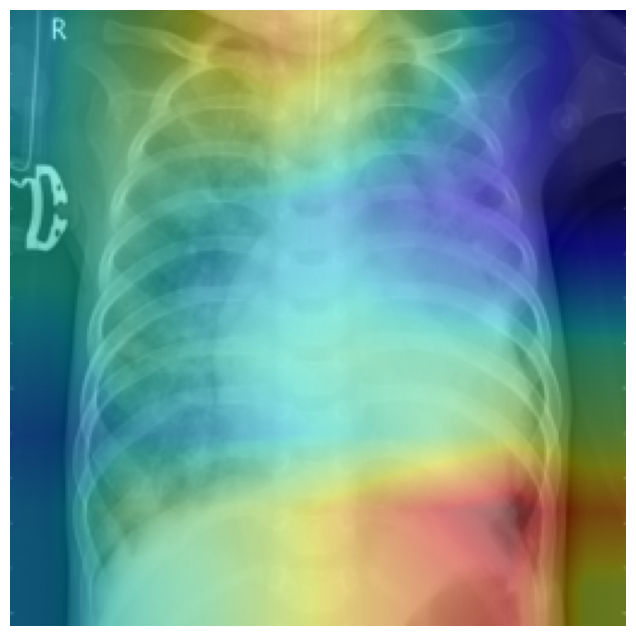

predict : 1 / ans : 1



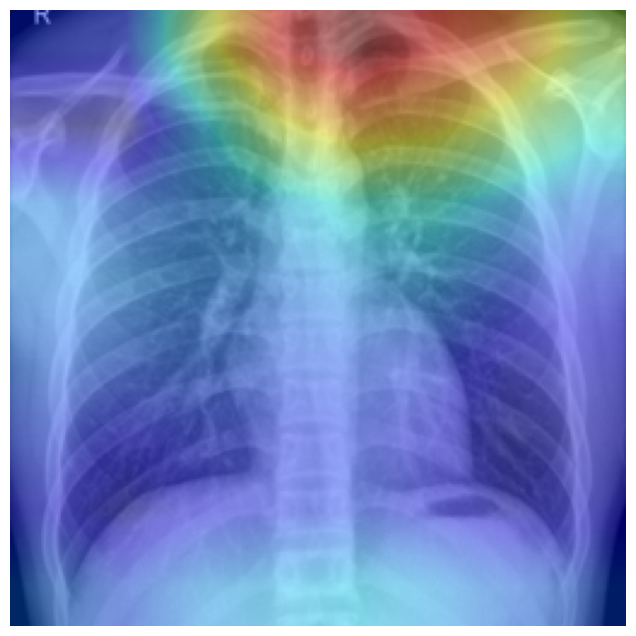

predict : 1 / ans : 0



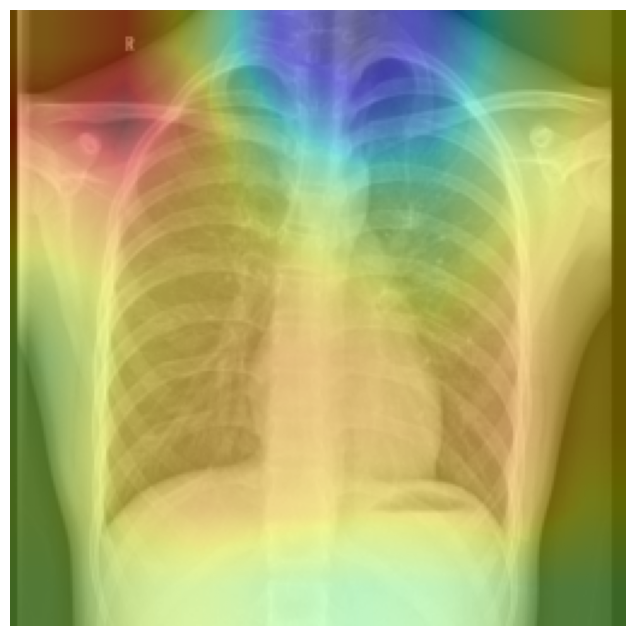

predict : 0 / ans : 0



In [49]:
last_ans = []
for i in range(5):
    img = test_dataset[-(i + 1)][0].unsqueeze(0).cuda()
    ans = test_dataset[-(i + 1)][1].cuda()

    class_idx = CAM_View_res(img, ResNet_G)
    last_ans.append(class_idx)
    print(f'predict : {last_ans[i]} / ans : {ans}')
    print()

### DenseNet

In [15]:
def CAM_View_dns(img, model):
    model.eval()

    mean = torch.tensor([0.5]).to(img.device)
    std = torch.tensor([0.5]).to(img.device)
    img_display = img * std + mean

    features_extractor = model.features
    output = model(img)

    class_idx = int(output.argmax())

    weights = model.classifier.weight[class_idx].reshape(-1, 1, 1)
    features_output = features_extractor(img).squeeze()

    cam = features_output * weights
    cam = torch.sum(cam, dim=0)

    cam = F.interpolate(
        input= cam.unsqueeze(0).unsqueeze(0),
        size=(img.shape[2], img.shape[3]),
        mode="bilinear"
    ).squeeze().cpu().detach().numpy()

    # 시각화
    plt.figure(figsize=(8, 8))
    plt.imshow(img_display.cpu().squeeze(), cmap="gray")
    plt.imshow(cam, cmap="jet", alpha=0.4)
    plt.axis("off")
    plt.show()

    return class_idx

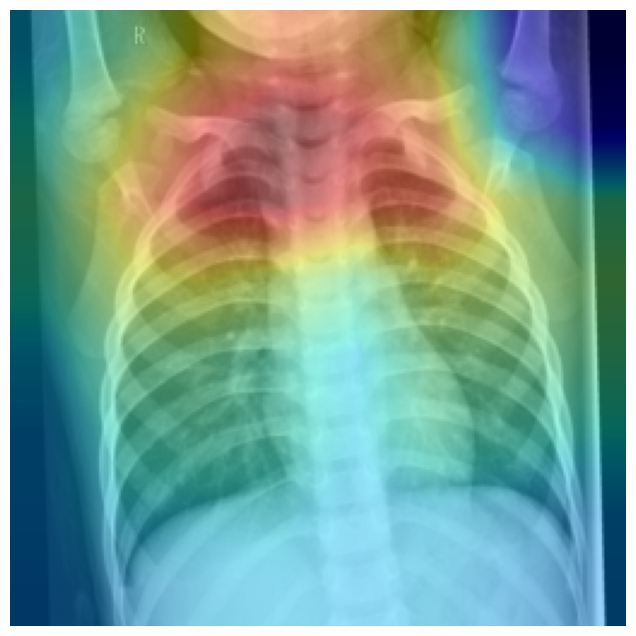

predict : 0 / ans : 0



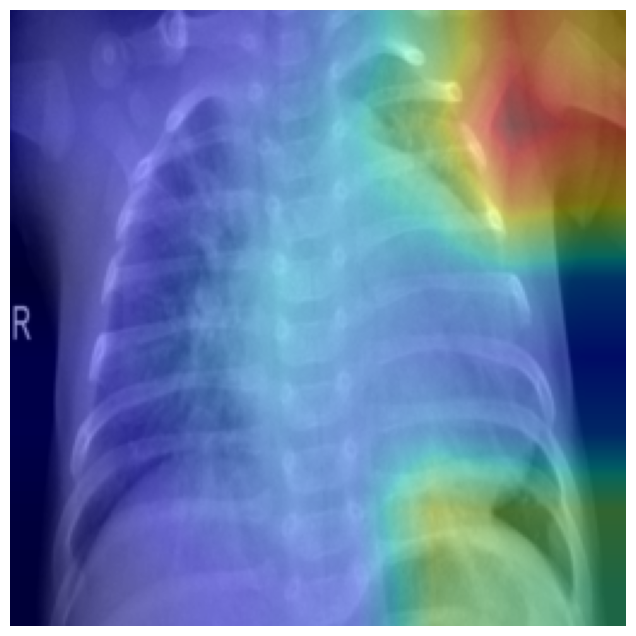

predict : 1 / ans : 1



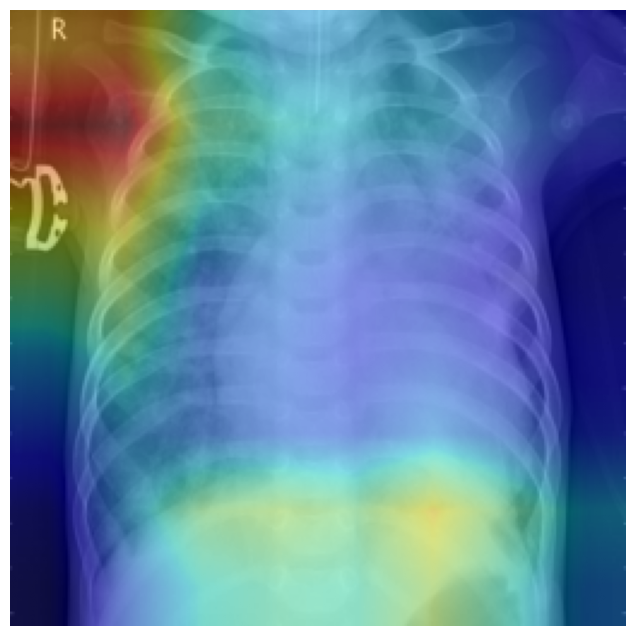

predict : 1 / ans : 1



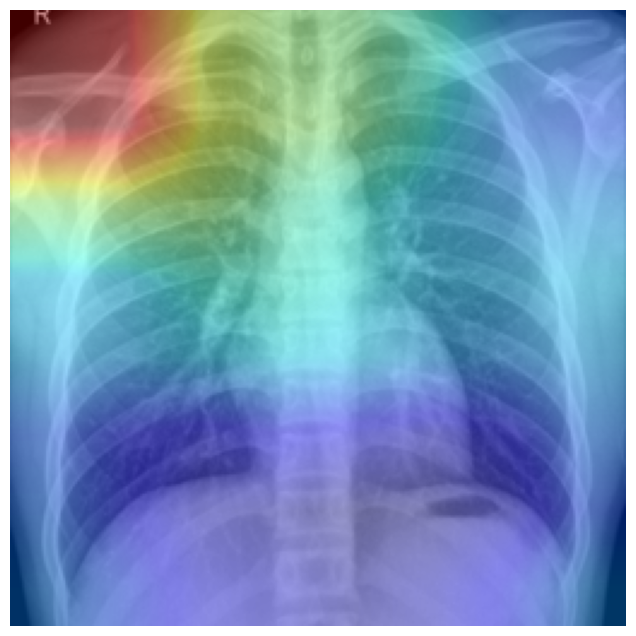

predict : 1 / ans : 0



In [51]:
last_ans = []
for i in range(4):
    img = test_dataset[-(i + 1)][0].unsqueeze(0).cuda()
    ans = test_dataset[-(i + 1)][1].cuda()
    class_idx = CAM_View_dns(img, DenseNet_G.cuda())
    last_ans.append(class_idx)
    print(f'predict : {last_ans[i]} / ans : {ans}')
    print()


**It appears that the training process is not functioning correctly.  
In particular, the fact that weights are being applied to the R part  
in the image indicates that we need to consider an alternative approach.  
We will crop the images to exclude the R part and retrain the model.**


## 3) Crop

Considering the issue analyzed above, we will add cropping in the image preprocessing step and retrain the model.

The rest of the process, excluding the cropping, will remain the same as in the previous code.

In [6]:
class make_datas_CROP(Dataset):
    def __init__(self, path):
        N_path = os.path.join(path, 'NORMAL')
        P_path = os.path.join(path, 'PNEUMONIA')

        self.images = []
        self.labels = []

        for p in os.listdir(P_path):
            self.images.append(os.path.join(P_path, p))
            self.labels.append(1)

        for n in os.listdir(N_path):
            self.images.append(os.path.join(N_path, n))
            self.labels.append(0)

        data = list(zip(self.images, self.labels))
        random.shuffle(data)
        self.images, self.labels = zip(*data)

        self.transform = transforms.Compose([
                        transforms.Resize((224, 224)),
                        transforms.CenterCrop((180,180)),  # 180 * 180 Crop
                        transforms.Grayscale(num_output_channels=1),
                        transforms.ToTensor(),
                    ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)

        label = self.labels[idx]

        image = self.transform(image)
        image = image.float()

        return image, torch.tensor(label)

In [7]:
train_dataset = make_datas_CROP(train_path)
val_dataset = make_datas_CROP(val_path)
test_dataset = make_datas_CROP(test_path)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

### ResNet_Crop

100%|██████████| 163/163 [00:33<00:00,  4.87batch/s, accuracy=95.5, loss=0.125] 


Loss: 0.1251, Accuracy: 95.48%
Validation Accuracy: 62.50%


100%|██████████| 163/163 [00:34<00:00,  4.78batch/s, accuracy=97.8, loss=0.0526]


Loss: 0.0526, Accuracy: 97.81%
Validation Accuracy: 68.75%


100%|██████████| 163/163 [00:34<00:00,  4.79batch/s, accuracy=99, loss=0.0282]   


Loss: 0.0282, Accuracy: 98.98%
Validation Accuracy: 68.75%
Test Accuracy: 84.94%
precision : 0.808333
recall : 0.994872
f1_score : 0.891954



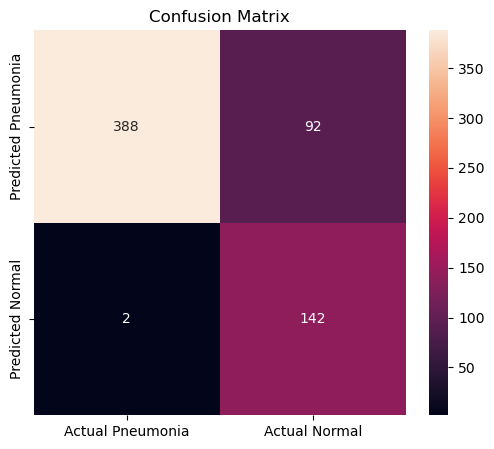

In [12]:
model = ResNet_G.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ResNet_G.parameters(), lr=0.0001)
epochs = 3
for i in range(epochs):
    train_model(model, train_loader, val_loader, criterion, optimizer)

visualization()

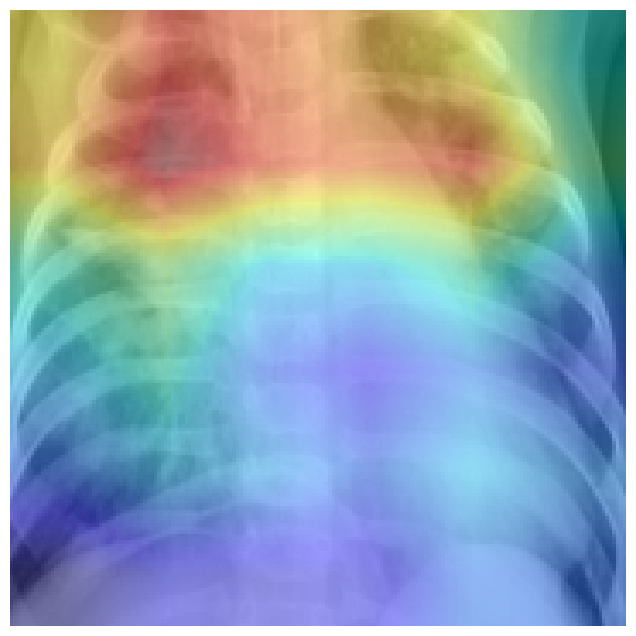

predict : 1 / ans : 1



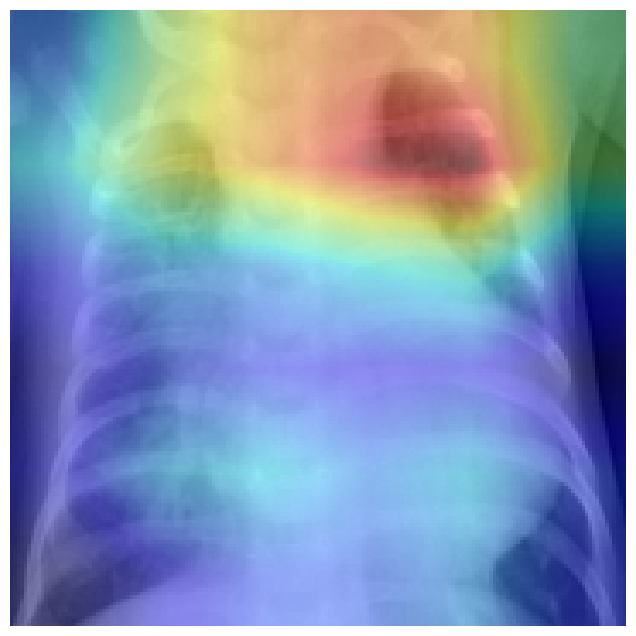

predict : 1 / ans : 1



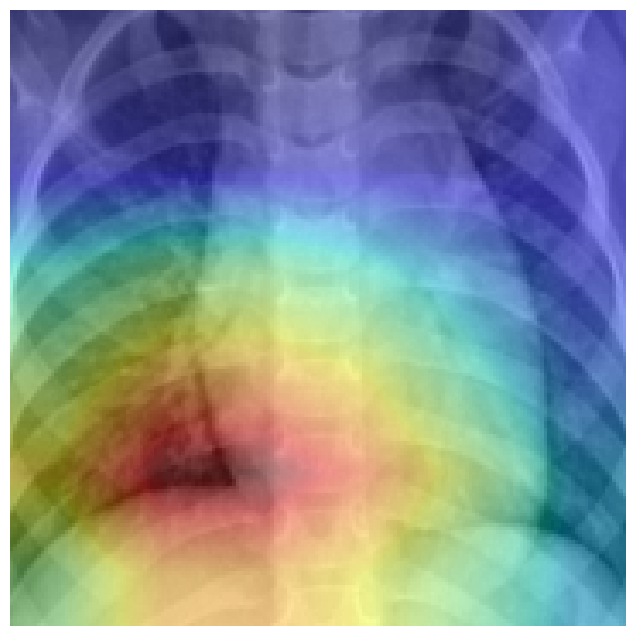

predict : 0 / ans : 0



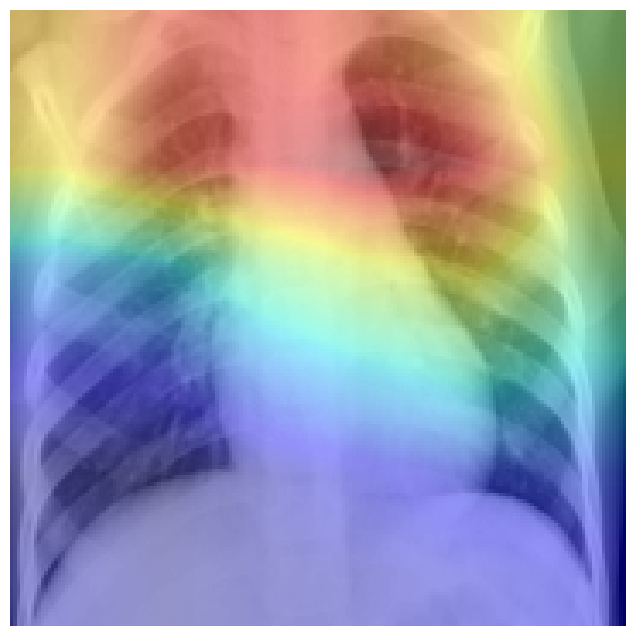

predict : 1 / ans : 0



In [16]:
last_ans = []
for i in range(4):
    img = test_dataset[-(i + 1)][0].unsqueeze(0).cuda()
    ans = test_dataset[-(i + 1)][1].cuda()

    class_idx = CAM_View_res(img, ResNet_G)
    last_ans.append(class_idx)
    print(f'predict : {last_ans[i]} / ans : {ans}')
    print()

### DenseNet_Crop

100%|██████████| 163/163 [00:43<00:00,  3.75batch/s, accuracy=95.1, loss=0.133] 


Loss: 0.1330, Accuracy: 95.05%
Validation Accuracy: 56.25%


100%|██████████| 163/163 [00:43<00:00,  3.79batch/s, accuracy=98.3, loss=0.0518]


Loss: 0.0518, Accuracy: 98.31%
Validation Accuracy: 56.25%


100%|██████████| 163/163 [00:42<00:00,  3.81batch/s, accuracy=99.1, loss=0.0288]


Loss: 0.0288, Accuracy: 99.06%
Validation Accuracy: 68.75%
Test Accuracy: 82.05%
precision : 0.780242
recall : 0.992308
f1_score : 0.873589



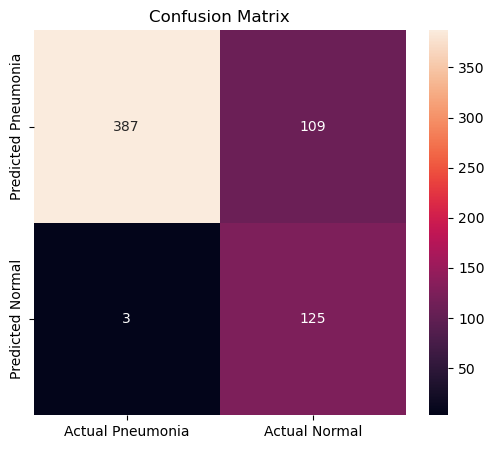

In [17]:
model = DenseNet_G.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(DenseNet_G.parameters(), lr=0.0001)

epochs = 3
for i in range(epochs):
    train_model(model, train_loader, val_loader, criterion, optimizer)

visualization()

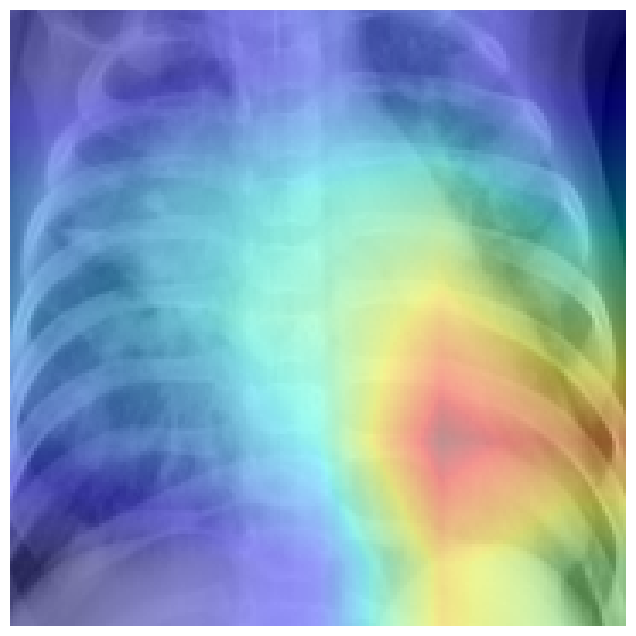

predict : 1 / ans : 1



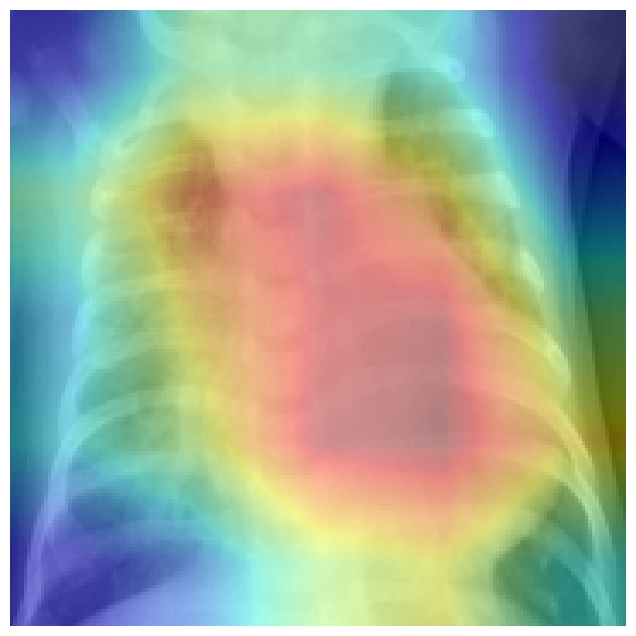

predict : 1 / ans : 1



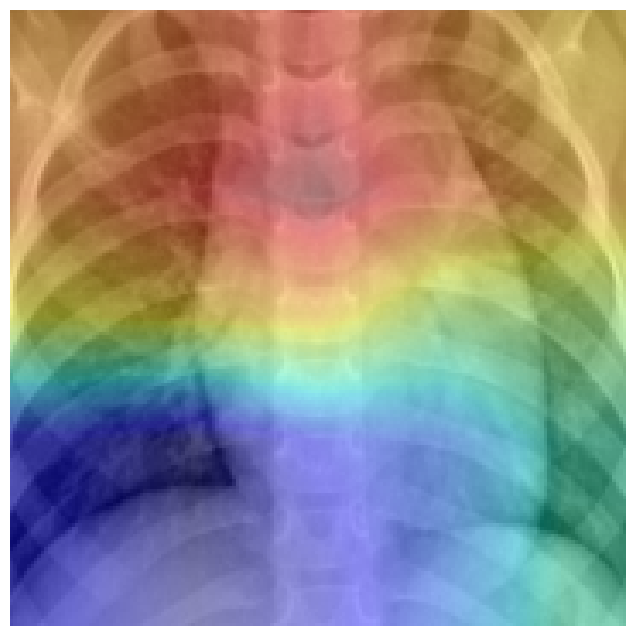

predict : 1 / ans : 0



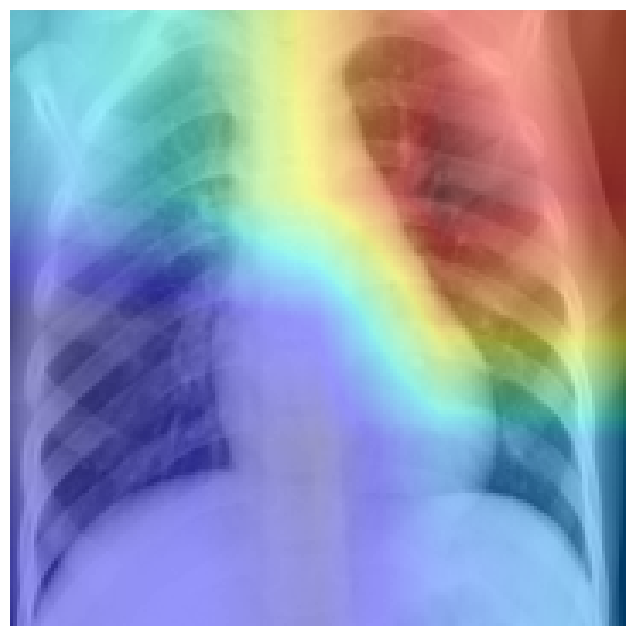

predict : 1 / ans : 0



In [18]:
last_ans = []
for i in range(4):
    img = test_dataset[-(i + 1)][0].unsqueeze(0).cuda()
    ans = test_dataset[-(i + 1)][1].cuda()
    class_idx = CAM_View_dns(img, DenseNet_G.cuda())
    last_ans.append(class_idx)
    print(f'predict : {last_ans[i]} / ans : {ans}')
    print()

**Even after removing the R part of the image, the results were almost identical to the previous ones.  
This indicates that the R part was not a significant issue.  
Additionally, in disease classification models, the most important metric is recall.  
A higher recall means fewer misses, so a model with a recall close to 100% can be understood as a well-trained model.**